In [1]:
# Import modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import optuna

/home/sjbaek/miniforge3/envs/torchenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f'Using device: {device}')
        print(f'GPU: {torch.cuda.get_device_name(0)}')
    else:
        print(f'Using device: {device}')

    return device

In [3]:
def norm_data(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }

    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]
    return ndf

In [4]:
def seq_data(ndf):
    seq = []
    # CBLA, CAK만 제거: 학습 불안정성 때문에
    # 전류(I)는 포함: ground truth로 사용하여 예측 성능 비교
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        seq.append(exp_data[feature_cols].values)
    
    return seq

In [5]:
def pad_seq(seq):
    max_len = max([len(seq) for seq in seq])
    seq_len = [len(seq) for seq in seq]
    pad_seq = pad_sequence([torch.tensor(seq) for seq in seq], batch_first=True, padding_value=-1)

    return pad_seq, seq_len, max_len

In [6]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [ ]:
def kfold_dataloaders(dataset, k_folds=5, batch_size=4, random_state=87):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    dataloaders = []
    batch_size = math.ceil(len(dataset)/k_folds)
    
    for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
        print(f"Fold {fold + 1}: Train size = {len(train_indices)}, Val size = {len(val_indices)}")
        
        # Create subsets for train and validation
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        dataloaders.append((train_loader, val_loader))
    return dataloaders

In [8]:
class LayerNormLSTMCell(nn.Module):
    """LSTM Cell with Layer Normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node
        
        # Input-to-hidden and hidden-to-hidden transformations
        self.weight_ih = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.weight_hh = nn.Linear(hidden_node, 4 * hidden_node, bias=False)
        
        # Layer normalization for each gate
        self.ln_i = nn.LayerNorm(hidden_node)  # Input gate
        self.ln_f = nn.LayerNorm(hidden_node)  # Forget gate  
        self.ln_g = nn.LayerNorm(hidden_node)  # Cell gate
        self.ln_o = nn.LayerNorm(hidden_node)  # Output gate
        
        # Cell state layer norm
        self.ln_c = nn.LayerNorm(hidden_node)
        
    def forward(self, input, hidden):
        h_prev, c_prev = hidden
        
        # Input-to-hidden and hidden-to-hidden transformations
        gi = self.weight_ih(input)    # [batch, 4*hidden_size] - 입력에 대한 4개 게이트 계산
        gh = self.weight_hh(h_prev)   # [batch, 4*hidden_size] - 이전 히든 상태에 대한 4개 게이트 계산
        i_i, i_f, i_g, i_o = gi.chunk(4, 1)
        h_i, h_f, h_g, h_o = gh.chunk(4, 1)
        
        # Apply layer normalization to each gate
        i_gate = torch.sigmoid(self.ln_i(i_i + h_i))
        f_gate = torch.sigmoid(self.ln_f(i_f + h_f))  
        g_gate = torch.tanh(self.ln_g(i_g + h_g))
        o_gate = torch.sigmoid(self.ln_o(i_o + h_o))
        
        # Update cell state with layer norm
        c_new = f_gate * c_prev + i_gate * g_gate
        c_new = self.ln_c(c_new)
        
        # Update hidden state
        h_new = o_gate * torch.tanh(c_new)
        
        return h_new, c_new

class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, nlayer, dropout=0.2):
        super().__init__()
        self.hidden_node = hidden_node
        self.nlayer = nlayer
        self.input_size = input_node
        
        # Create LayerNorm LSTM layers
        self.lstm_cells = nn.ModuleList()
        
        # First layer: input_size -> hidden_size
        self.lstm_cells.append(LayerNormLSTMCell(input_node, hidden_node))
        
        # Additional layers: hidden_size -> hidden_size
        for _ in range(nlayer - 1):
            self.lstm_cells.append(LayerNormLSTMCell(hidden_node, hidden_node))
        
        # Dropout between layers (only applied if nlayer > 1)
        self.dropout = nn.Dropout(dropout) if nlayer > 1 else nn.Identity()
        
        # Final layer norm and dropout
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        """
        시계열 상태 시퀀스를 처리하여 각 시점의 hidden state 추출
        
        Args:
            x: [batch_size, seq_len, input_size] - BMED 시스템 상태 시퀀스
            seq_len: [batch_size] - 각 시퀀스의 실제 길이
            
        Returns:
            hidden_states: [batch_size, seq_len, hidden_size] - 각 시점의 누적된 hidden state
        """
        
        # 입력 검증
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        batch_size, max_len, input_node = x.size()
        device = x.device
        
        # 초기 hidden/cell states 초기화
        h_states = []
        c_states = []
        for _ in range(self.nlayer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        # 각 시점별 출력 저장
        outputs = []
        
        # 시점별로 순차 처리
        for t in range(max_len):
            x_t = x[:, t, :]  # [batch_size, input_node]
            
            # 각 LSTM layer 순차 처리
            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                # 상태 업데이트
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new
                
                # 다음 레이어 입력 준비 (dropout 적용)
                if layer_idx < len(self.lstm_cells) - 1:  # 마지막 레이어가 아닌 경우
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new
            
            outputs.append(layer_input)
        
        # [batch_size, seq_len, hidden_size] 형태로 변환
        output_tensor = torch.stack(outputs, dim=1)
        
        # 시퀀스 길이에 따른 마스킹 (패딩 부분 0으로 설정)
        seq_len_cpu = seq_len.detach().cpu().long()
        
        # 시퀀스 길이 유효성 검사
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
        
        # 마스크 생성 및 적용
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)  # [batch, seq_len, 1]
        
        # 마스킹 적용
        masked_output = output_tensor * mask
        
        # Final normalization and dropout
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

In [9]:
class PhysicalChangeDecoder(nn.Module):
    """
    Hidden state로부터 BMED 시스템의 물리적 변화량과 새로운 전류값을 디코딩하는 MLP
    출력: [dVA, dVB, dNALA, dNBK, nI] - 5개 물리적 변화량 (CBLA, CAK 제거로 dNBLA, dNAK 불필요)
    """
    def __init__(self, hidden_size, output_size, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()

        if num_nodes is None:
            num_nodes = hidden_size
        
        self.layers = nn.ModuleList()

        # 첫 번째 레이어: hidden_size → num_nodes
        self.layers.append(nn.Linear(hidden_size, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # 중간 은닉층들: num_nodes → num_nodes
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # 마지막 출력층: num_nodes → output_size (5개 물리적 변화량)
        self.layers.append(nn.Linear(num_nodes, output_size))

    def forward(self, hidden_states):
        """
        Hidden state를 물리적 변화량으로 디코딩
        
        Args:
            hidden_states: [batch_size, seq_len, hidden_size] - 시점별 hidden state
            
        Returns:
            physical_changes: [batch_size, seq_len, 5] - 물리적 변화량
                [dVA, dVB, dNALA, dNBK, nI]
        """
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
class PhysicsConstraintLayer(nn.Module):
    """
    물리적 변화량을 실제 시스템 상태로 변환하면서 물리적 제약 조건을 적용
    Bipolar membrane electrodialysis 시스템의 물리 법칙 기반 상태 업데이트
    CBLA, CAK는 완전히 제거되어 더 이상 존재하지 않음
    전류는 dependent variable이므로 input에 포함하지 않고 output으로만 예측
    """
    def __init__(self, eps=1e-1):
        super().__init__()
        self.eps = eps  # division by zero 방지
        
    def forward(self, physical_changes, current_state):
        """
        물리적 변화량을 현재 상태에 적용하여 다음 상태 계산
        
        Args:
            physical_changes: [batch, seq, 5] - [dVA, dVB, dNALA, dNBK, nI]
            current_state: [batch, seq, 9] - 현재 BMED 시스템 상태 (전류 제외)
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK
                
        Returns:
            next_state: [batch, seq, 10] - 물리 제약이 적용된 다음 상태
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I
        """
        # 입력 차원 검증
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 9:
            raise ValueError(f"Expected 9 state features, got {current_state.size(-1)}")
            
        if physical_changes.size(-1) != 5:
            raise ValueError(f"Expected 5 physical changes, got {physical_changes.size(-1)}")
        
        # 현재 상태 변수 추출 (9개)
        V = current_state[..., 0:1]     # 전압 (고정값)
        E = current_state[..., 1:2]     # 외부 전해질 농도 (고정값)
        VF = current_state[..., 2:3]    # Feed 부피
        VA = current_state[..., 3:4]    # Acid 부피
        VB = current_state[..., 4:5]    # Base 부피
        CFLA = current_state[..., 5:6]  # Feed LA 농도
        CALA = current_state[..., 6:7]  # Acid LA 농도
        CFK = current_state[..., 7:8]   # Feed K 농도
        CBK = current_state[..., 8:9]   # Base K 농도

        # 물질량 계산 (농도 × 부피) - CBLA, CAK 관련은 완전 제거
        NFLA = CFLA * VF
        NALA = CALA * VA  
        NFK = CFK * VF
        NBK = CBK * VB

        # 물리적 변화량 추출 (5개)
        dVA = physical_changes[..., 0:1]    # Acid 부피 변화량
        dVB = physical_changes[..., 1:2]    # Base 부피 변화량
        dNALA = physical_changes[..., 2:3]  # Acid LA 물질량 변화량 (F→A)
        dNBK = physical_changes[..., 3:4]   # Base K 물질량 변화량 (F→B)
        nI = physical_changes[..., 4:5]     # 새로운 전류값 (모델이 예측)

        # 새로운 부피 계산
        nVF = VF - dVA - dVB
        nVA = VA + dVA        
        nVB = VB + dVB        
        
        # 물질 이동량을 일방향으로 제한
        dNALA_clipped = torch.clamp(dNALA, min=0)  # F→A 이동만
        dNBK_clipped = torch.clamp(dNBK, min=0)    # F→B 이동만
        
        # 새로운 물질량 계산 (CBLA, CAK 관련 제거)
        nNFLA = NFLA - dNALA_clipped  # Feed에서 LA 유출
        nNALA = NALA + dNALA_clipped  # Acid로 LA 유입
        nNFK = NFK - dNBK_clipped     # Feed에서 K 유출  
        nNBK = NBK + dNBK_clipped     # Base로 K 유입
        
        # 물리적 제약 조건 적용 (양수 유지)
        nVF = torch.clamp(nVF, min=self.eps)
        nVA = torch.clamp(nVA, min=self.eps)
        nVB = torch.clamp(nVB, min=self.eps)
        
        # 물질량 음수 방지
        nNFLA = torch.clamp(nNFLA, min=0)
        nNALA = torch.clamp(nNALA, min=0)
        nNFK = torch.clamp(nNFK, min=0)
        nNBK = torch.clamp(nNBK, min=0)
        
        # 새로운 농도 계산
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB
        
        # 전류는 양수 제약
        nI = torch.clamp(nI, min=0)

        # 새로운 상태 조립 (10개 변수, CBLA, CAK 완전 제거, 전류는 예측 결과로 추가)
        next_state = torch.cat([
            V, E,  # 고정값: 전압, 외부 전해질 농도
            nVF, nVA, nVB,  # 새로운 부피
            nCFLA, nCALA,   # 새로운 LA 농도 (CBLA 제거)
            nCFK, nCBK,     # 새로운 K 농도 (CAK 제거)
            nI  # 새로운 전류 (모델이 예측한 dependent variable)
        ], dim=-1)
        
        return next_state

In [11]:
class BMEDAutoregressiveModel(nn.Module):
    """
    BMED 시스템의 시계열 상태 예측을 위한 자기회귀 모델
    
    구조:
    1. StateExtr: LSTM으로 시계열 패턴의 hidden state 추출
    2. PhysicalChangeDecoder: Hidden state를 물리적 변화량으로 디코딩  
    3. PhysicsConstraintLayer: 물리 법칙 적용하여 다음 상태 계산
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = StateExtr(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_states, seq_lengths):
        """
        현재 시점까지의 상태들로부터 다음 상태들 예측
        
        Args:
            current_states: [batch, seq_len, 9] - 현재까지의 전류를 제외한한 BMED 시스템 상태들
            seq_lengths: [batch] - 각 시퀀스의 실제 길이
            
        Returns:
            next_states: [batch, seq_len, 10] - 예측된 다음 시점 상태들 (전류 포함)
        """
        # 1. LSTM으로 각 시점의 hidden state 추출 (과거 정보 누적)
        hidden_states = self.state_extractor(current_states, seq_lengths)
        
        # 2. Hidden state를 물리적 변화량으로 디코딩
        physical_changes = self.physical_decoder(hidden_states)
        
        # 3. 물리적 제약 조건을 적용하여 다음 상태 계산
        next_states = self.physics_constraint(physical_changes, current_states)
        
        return next_states

In [12]:
def masked_mse_loss(predictions, targets, seq_lengths):
    """
    개선된 마스킹된 MSE 손실 함수 - device 호환성, 안정성 강화
    물리적 의미가 개선되어 feature별 가중치 불필요
    
    Args:
        predictions: 모델 예측값 [batch_size, seq_len, features]
        targets: 실제 타겟값 [batch_size, seq_len, features]  
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        masked_loss: 패딩 부분을 제외한 평균 MSE 손실
    """
    # 입력 검증
    if predictions.shape != targets.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
    
    if predictions.size(0) != seq_lengths.size(0):
        raise ValueError(f"Batch size mismatch: predictions {predictions.size(0)} vs seq_lengths {seq_lengths.size(0)}")
    
    batch_size, max_len, features = predictions.shape
    
    # seq_lengths를 CPU로 이동하여 arange와 호환되도록 처리
    seq_lengths_cpu = seq_lengths.detach().cpu().long()
    
    # 시퀀스 길이 유효성 검사
    if (seq_lengths_cpu <= 0).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu <= 0]
        raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
    
    # 최대 길이 초과 검사
    if (seq_lengths_cpu > max_len).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu > max_len]
        raise ValueError(f"Sequence lengths exceed max_len: {invalid_lengths.tolist()} > {max_len}")
    
    # 마스크 생성: 실제 시퀀스 길이만큼만 True
    mask = torch.arange(max_len, device='cpu')[None, :] < seq_lengths_cpu[:, None]
    mask = mask.float().to(predictions.device)
    
    # 각 요소별 MSE 계산 (reduction='none')
    loss = F.mse_loss(predictions, targets, reduction='none')  # [batch, seq_len, features]
    
    # 마스크 적용하여 패딩 부분 제거
    masked_loss = loss * mask.unsqueeze(-1)  # [batch, seq_len, features]
    
    # 전체 손실 합계와 전체 valid elements 계산
    total_loss = masked_loss.sum()
    total_elements = mask.sum() * features
    
    # 0으로 나누기 방지
    if total_elements == 0:
        raise ValueError("No valid elements found after masking. Check sequence lengths and data.")
    
    masked_loss = total_loss / total_elements
    
    return masked_loss

In [13]:
def prepare_teacher_forcing_data(input_sequences, seq_lengths):
    """
    Teacher Forcing을 위한 입력-타겟 데이터 준비
    전류는 dependent variable이므로 input에서 제외하고 output에만 포함
    
    Args:
        input_sequences: 전체 시퀀스 [batch_size, seq_len, 10] (CBLA, CAK 제거된 상태)
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        inputs: [t0, t1, ..., t_{n-1}] 현재 상태들 [batch_size, seq_len-1, 9] (전류 제외)
        targets: [t1, t2, ..., t_n] 다음 상태들 [batch_size, seq_len-1, 10] (전류 포함)
        target_seq_lengths: 타겟 시퀀스 길이 (1씩 감소)
    """
    # 입력: 마지막 시점 제외 [:-1] 및 전류 제외 [:-1]
    inputs = input_sequences[:, :-1, :-1]  # 전류 제외하여 9개 features
    
    # 타겟: 첫 번째 시점 제외 [1:], 전류 포함하여 10개 features
    targets = input_sequences[:, 1:, :]
    
    # 타겟 시퀀스 길이는 1씩 감소 (마지막 시점 예측 불가)
    if (seq_lengths - 1 < 1).any():
        invalid_lengths = seq_lengths[seq_lengths - 1 < 1]
        raise ValueError(f"타겟 시퀀스 길이가 0보다 작아질 수 없습니다. 잘못된 seq_lengths: {invalid_lengths.tolist()}")
    target_seq_lengths = seq_lengths - 1
    
    return inputs, targets, target_seq_lengths

In [ ]:
class BMEDHyperparameterOptimizer:
    """
    BMED 자기회귀 모델을 위한 K-fold CV 기반 하이퍼파라미터 최적화 클래스
    물리적으로 개선된 구조: Input 9개 (전류 제외), Output 5개 (변화량)
    """
    def __init__(self, dataloaders, device=None):
        self.dataloaders = dataloaders
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 하이퍼파라미터 범위 정의
        self.param_ranges = {
            'hidden_size': {'low': 16, 'high': 128, 'step': 16},
            'num_layers': {'low': 2, 'high': 4},
            'extractor_dropout': {'low': 0.1, 'high': 0.5},
            'decoder_layers': {'low': 2, 'high': 4},
            'decoder_nodes': {'low': 16 ,'high': 128, 'step': 16},
            'decoder_dropout': {'low': 0.1, 'high': 0.5},
            'learning_rate': {'low': 1e-5, 'high': 1e-3, 'log': True},
            'weight_decay': {'low': 1e-6, 'high': 1e-4, 'log': True}
        }
        
        # 학습 설정 - 작은 데이터셋에 최적화
        self.train_config = {
            'epochs': 200,      # 더 많은 기회 제공
            'patience': 20,     # 더 관대한 early stopping
            'min_epochs': 50    # 충분한 학습 보장
        }
    
    def create_model(self, trial):
        """하이퍼파라미터 샘플링 및 모델 생성"""
        # 하이퍼파라미터 샘플링
        params = {}
        params['hidden_size'] = trial.suggest_int('hidden_size', **self.param_ranges['hidden_size'])
        params['num_layers'] = trial.suggest_int('num_layers', **self.param_ranges['num_layers'])
        params['extractor_dropout'] = trial.suggest_float('extractor_dropout', **self.param_ranges['extractor_dropout'])
        params['decoder_layers'] = trial.suggest_int('decoder_layers', **self.param_ranges['decoder_layers'])
        params['decoder_nodes'] = trial.suggest_int('decoder_nodes', **self.param_ranges['decoder_nodes'])
        params['decoder_dropout'] = trial.suggest_float('decoder_dropout', **self.param_ranges['decoder_dropout'])
        params['learning_rate'] = trial.suggest_float('learning_rate', **self.param_ranges['learning_rate'])
        params['weight_decay'] = trial.suggest_float('weight_decay', **self.param_ranges['weight_decay'])
        
        # 모델 파라미터 구성 - 물리적으로 개선된 구조
        model_params = {
            'state_extractor_params': {
                'input_node': 9,  # V, E, VF, VA, VB, CFLA, CALA, CFK, CBK (전류, CBLA, CAK 제외)
                'hidden_node': params['hidden_size'],
                'nlayer': params['num_layers'],
                'dropout': params['extractor_dropout']
            },
            'decoder_params': {
                'hidden_size': params['hidden_size'],
                'output_size': 5,  # dVA, dVB, dNALA, dNBK, nI (dNBLA, dNAK 제거)
                'num_layers': params['decoder_layers'],
                'num_nodes': params['decoder_nodes'],
                'dropout': params['decoder_dropout']
            }
        }
        
        # 옵티마이저 파라미터
        optimizer_params = {
            'lr': params['learning_rate'],
            'weight_decay': params['weight_decay']
        }
        
        return model_params, optimizer_params
    
    def train_single_fold(self, model_params, optimizer_params, train_loader, val_loader):
        """단일 fold 학습 - 실제 데이터 분포 기반 동적 가중치 적용"""
        try:
            # 모델 초기화
            model = BMEDAutoregressiveModel(model_params['state_extractor_params'], model_params['decoder_params']).to(self.device)
            optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
            
            # 실제 데이터셋 크기 기반 동적 가중치 계산
            train_samples = len(train_loader.dataset)
            val_samples = len(val_loader.dataset)
            total_samples = train_samples + val_samples
            
            train_weight = train_samples / total_samples
            val_weight = val_samples / total_samples
            
            print(f"Fold 데이터 분포 - Train: {train_samples}({train_weight:.3f}), Val: {val_samples}({val_weight:.3f})")
            
            best_total_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(self.train_config['epochs']):
                # 학습
                model.train()
                train_loss = 0.0
                train_batches = 0
                
                for input_seq, seq_lengths in train_loader:
                    try:
                        input_seq = input_seq.to(self.device)
                        seq_lengths = seq_lengths.to(self.device)
                        
                        # Teacher forcing 데이터 준비 (전류 제외한 input, 전류 포함한 target)
                        inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
                        
                        # Forward pass
                        optimizer.zero_grad()
                        predictions = model(inputs, target_seq_lengths)
                        loss = masked_mse_loss(predictions, targets, target_seq_lengths)
                        
                        # Backward pass
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
                        optimizer.step()
                        
                        train_loss += loss.item()
                        train_batches += 1
                        
                    except Exception as e:
                        print(f"Training batch error: {str(e)}")
                        continue
                
                if train_batches == 0:
                    return float('inf')
                
                train_loss = train_loss / train_batches
                
                # 검증
                model.eval()
                val_loss = 0.0
                val_batches = 0
                
                with torch.no_grad():
                    for input_seq, seq_lengths in val_loader:
                        try:
                            input_seq = input_seq.to(self.device)
                            seq_lengths = seq_lengths.to(self.device)
                            
                            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
                            predictions = model(inputs, target_seq_lengths)
                            loss = masked_mse_loss(predictions, targets, target_seq_lengths)
                            
                            val_loss += loss.item()
                            val_batches += 1
                            
                        except Exception as e:
                            print(f"Validation batch error: {str(e)}")
                            continue
                
                if val_batches == 0:
                    return float('inf')
                
                val_loss = val_loss / val_batches
                
                # Total loss 계산 (실제 데이터 분포 기반 동적 가중치)
                total_loss = train_weight * train_loss + val_weight * val_loss
                
                # Early stopping (total_loss 기준)
                if total_loss < best_total_loss:
                    best_total_loss = total_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # 최소 에포크 후 early stopping 적용
                if epoch >= self.train_config['min_epochs'] and patience_counter >= self.train_config['patience']:
                    break
            
            return best_total_loss
            
        except Exception as e:
            print(f"Fold training error: {str(e)}")
            return float('inf')
    
    def objective(self, trial):
        """Optuna objective 함수 - 모든 fold 완료 후 평균 반환"""
        try:
            # 모델 및 옵티마이저 파라미터 생성
            model_params, optimizer_params = self.create_model(trial)
            
            # K-fold 교차검증 - 모든 fold 실행
            fold_losses = []
            for fold_idx, (train_loader, val_loader) in enumerate(self.dataloaders):
                print(f"\n=== Fold {fold_idx + 1}/{len(self.dataloaders)} ===")
                fold_loss = self.train_single_fold(
                    model_params, optimizer_params, 
                    train_loader, val_loader
                )
                
                if fold_loss == float('inf'):
                    return float('inf')
                
                fold_losses.append(fold_loss)
                print(f"Fold {fold_idx + 1} Total Loss: {fold_loss:.6f}")
            
            # 평균 total loss 반환 (모든 fold 완료)
            mean_loss = sum(fold_losses) / len(fold_losses)
            print(f"Trial Mean Loss: {mean_loss:.6f}")
            return mean_loss
            
        except Exception as e:
            print(f"Trial error: {str(e)}")
            import traceback
            traceback.print_exc()
            return float('inf')

def optimize_bmed_hyperparameters(trial, dataloaders):
    """Optuna를 위한 래퍼 함수"""
    optimizer = BMEDHyperparameterOptimizer(dataloaders)
    return optimizer.objective(trial)

In [15]:
# 데이터 로드 및 전처리
print("데이터 로드 및 전처리 중...")

# 데이터 로드 및 정규화
ndf = norm_data('BMED_DATA_AG.csv')
# 시퀀스 데이터 구성
seq = seq_data(ndf)
pad_seq, seq_len, max_seq_len = pad_seq(seq)

# 데이터셋 생성
dataset = gen_dataset(pad_seq, seq_len)

# K-fold 데이터로더 생성
dataloaders = kfold_dataloaders(dataset, k_folds=5, batch_size=8, random_state=42)

print(f"\n데이터 전처리 완료!")
print(f"- 시퀀스 개수: {len(seq)}")
print(f"- 최대 시퀀스 길이: {max_seq_len}")
print(f"- K-fold 수: {len(dataloaders)}")
print(f"- 각 fold는 (train_loader, val_loader) 튜플")

데이터 로드 및 전처리 중...
Fold 1: Train size = 23, Val size = 6
Fold 2: Train size = 23, Val size = 6
Fold 3: Train size = 23, Val size = 6
Fold 4: Train size = 23, Val size = 6
Fold 5: Train size = 24, Val size = 5

데이터 전처리 완료!
- 시퀀스 개수: 29
- 최대 시퀀스 길이: 33
- K-fold 수: 5
- 각 fold는 (train_loader, val_loader) 튜플


In [16]:
# BMED 자기회귀 모델 하이퍼파라미터 최적화 실행
print("BMED 하이퍼파라미터 최적화 준비 중...")

# SQLite 데이터베이스에 study 결과 저장
study_name = "bmed_autoregressive_optimization"
storage_name = "sqlite:///bmed_optuna_study.db"

# Optuna study 생성 - K-fold CV 기반
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='minimize',  # 손실을 최소화
    pruner=optuna.pruners.NopPruner(),  # K-fold CV와 호환을 위해 pruning 비활성화
    sampler=optuna.samplers.TPESampler(seed=42),
    load_if_exists=True  # 기존 study가 있으면 이어서 실행
)

print("BMED 자기회귀 모델 하이퍼파라미터 최적화 시작...")
print(f"Study 이름: {study_name}")
print(f"저장 위치: {storage_name}")
print("최적화 방식: K-fold Cross Validation")
print("=" * 50)

# 최적화 실행 - 품질 중심
study.optimize(
    lambda trial: optimize_bmed_hyperparameters(trial, dataloaders), 
    n_trials=1000,  # 품질 중심의 최적화
)

print("\n" + "=" * 50)
print("최적화 완료!")
print("=" * 50)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\n최적의 검증 손실: {study.best_value:.6f}")
print(f"완료된 trial 수: {len(study.trials)}")
print(f"성공한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"실패한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")

# 결과를 JSON 파일로도 저장
import json
import datetime

results_dict = {
    'study_name': study_name,
    'model_type': 'BMED_Autoregressive',
    'optimization_method': 'K-fold_Cross_Validation',
    'best_params': study.best_params,
    'best_value': study.best_value,
    'n_trials': len(study.trials),
    'timestamp': datetime.datetime.now().isoformat(),
    'trials': [
        {
            'number': trial.number,
            'value': trial.value,
            'params': trial.params,
            'state': trial.state.name
        }
        for trial in study.trials
    ]
}

with open('bmed_autoregressive_optimization_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_dict, f, indent=2, ensure_ascii=False)

print(f"\n결과 저장 완료:")
print(f"  - 데이터베이스: bmed_optuna_study.db")
print(f"  - JSON 파일: bmed_autoregressive_optimization_results.json")

BMED 하이퍼파라미터 최적화 준비 중...


[I 2025-08-13 11:38:25,594] Using an existing study with name 'bmed_autoregressive_optimization' instead of creating a new one.


BMED 자기회귀 모델 하이퍼파라미터 최적화 시작...
Study 이름: bmed_autoregressive_optimization
저장 위치: sqlite:///bmed_optuna_study.db
최적화 방식: K-fold Cross Validation

=== Fold 1/5 ===
Fold 데이터 분포 - Train: 23(0.793), Val: 6(0.207)
Fold 1 Total Loss: 0.024211

=== Fold 2/5 ===
Fold 데이터 분포 - Train: 23(0.793), Val: 6(0.207)
Fold 2 Total Loss: 0.030025

=== Fold 3/5 ===
Fold 데이터 분포 - Train: 23(0.793), Val: 6(0.207)
Fold 3 Total Loss: 0.039829

=== Fold 4/5 ===
Fold 데이터 분포 - Train: 23(0.793), Val: 6(0.207)


[W 2025-08-13 11:44:52,483] Trial 3 failed with parameters: {'hidden_size': 128, 'num_layers': 4, 'extractor_dropout': 0.39279757672456206, 'decoder_layers': 3, 'decoder_nodes': 96, 'decoder_dropout': 0.16239780813448107, 'learning_rate': 1.3066739238053272e-05, 'weight_decay': 5.39948440978744e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/sjbaek/miniforge3/envs/torchenv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_9703/2150665104.py", line 26, in <lambda>
    lambda trial: optimize_bmed_hyperparameters(trial, dataloaders),
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_9703/1010390272.py", line 205, in optimize_bmed_hyperparameters
    return optimizer.objective(trial)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_9703/1010390272.py", line 180

KeyboardInterrupt: 

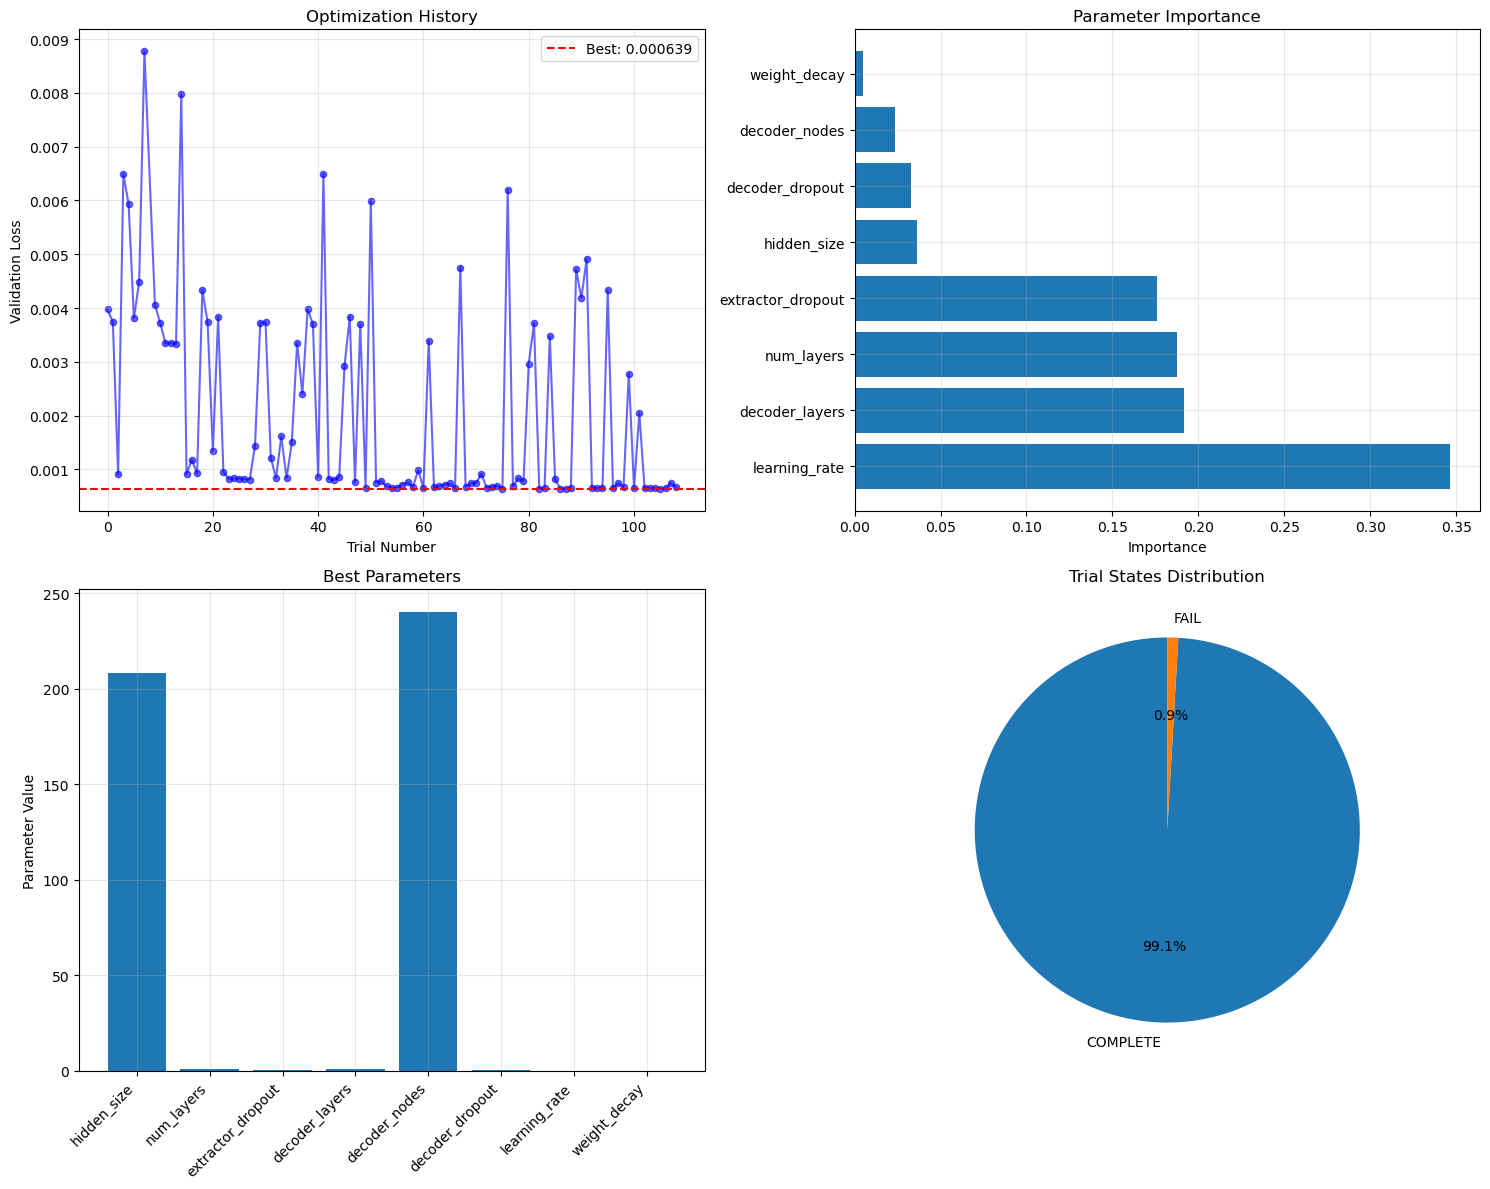


하이퍼파라미터 최적화 요약
총 실행된 trial 수: 109
성공한 trial 수: 108
Pruned trial 수: 0
실패한 trial 수: 1

최적의 검증 손실: 0.000639

최적 하이퍼파라미터:
  hidden_size: 208
  num_layers: 1
  extractor_dropout: 0.3822134344058207
  decoder_layers: 1
  decoder_nodes: 240
  decoder_dropout: 0.2423972008247526
  learning_rate: 0.001451859684698574
  weight_decay: 0.0006903725839689297

상위 5개 trial:
  1. Trial 82: Loss = 0.000639
  2. Trial 105: Loss = 0.000641
  3. Trial 87: Loss = 0.000641
  4. Trial 75: Loss = 0.000642
  5. Trial 86: Loss = 0.000644


In [ ]:
# Optuna 최적화 결과 시각화
import matplotlib.pyplot as plt
import numpy as np

# 1. 최적화 과정 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1-1. Optimization History
trials = study.trials
trial_values = [t.value for t in trials if t.value is not None]
trial_numbers = [t.number for t in trials if t.value is not None]

axes[0, 0].plot(trial_numbers, trial_values, 'b-', alpha=0.6)
axes[0, 0].scatter(trial_numbers, trial_values, c='blue', alpha=0.6, s=20)
axes[0, 0].axhline(y=study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
axes[0, 0].set_xlabel('Trial Number')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].set_title('Optimization History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1-2. Parameter Importance
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    axes[0, 1].barh(params, values)
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].set_title('Parameter Importance')
    axes[0, 1].grid(True, alpha=0.3)
except:
    axes[0, 1].text(0.5, 0.5, 'Parameter importance\nnot available', 
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Parameter Importance')

# 1-3. Best Parameters Visualization
best_params = study.best_params
param_names = list(best_params.keys())
param_values = list(best_params.values())

# 숫자형 파라미터만 시각화
numeric_params = [(name, val) for name, val in best_params.items() if isinstance(val, (int, float))]
if numeric_params:
    names, vals = zip(*numeric_params)
    axes[1, 0].bar(range(len(names)), vals)
    axes[1, 0].set_xticks(range(len(names)))
    axes[1, 0].set_xticklabels(names, rotation=45, ha='right')
    axes[1, 0].set_ylabel('Parameter Value')
    axes[1, 0].set_title('Best Parameters')
    axes[1, 0].grid(True, alpha=0.3)

# 1-4. Trial States Distribution
states = [t.state.name for t in study.trials]
unique_states, counts = np.unique(states, return_counts=True)

axes[1, 1].pie(counts, labels=unique_states, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Trial States Distribution')

plt.tight_layout()
plt.show()

# 2. 최적화 전후 비교 (만약 이전 결과가 있다면)
print("\n" + "="*50)
print("하이퍼파라미터 최적화 요약")
print("="*50)
print(f"총 실행된 trial 수: {len(study.trials)}")
print(f"성공한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Pruned trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"실패한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")
print(f"\n최적의 검증 손실: {study.best_value:.6f}")
print("\n최적 하이퍼파라미터:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 3. 상위 5개 trial 정보
print(f"\n상위 5개 trial:")
best_trials = sorted([t for t in study.trials if t.value is not None], 
                    key=lambda x: x.value)[:5]
for i, trial in enumerate(best_trials, 1):
    print(f"  {i}. Trial {trial.number}: Loss = {trial.value:.6f}")